# 16. 불안한 시선 이펙트 추가하기

## 10. 프로젝트: 카메라 앱에 당황한 표정 효과를 적용해보기

<img src="./image/emoji.jpg" />

그림처럼 놀라서 눈이 튀어나오는 듯 한 효과를 내보자. 우선 눈을 찾고, 눈에 효과를 적용해보자. 어려워 보여도 차근차근 한다면 충분히 간단한 프로토타입을 구현할 수 있다.

### **1. 이론 시간에 다룬 모델을 참고하여 딥러닝 모델을 설계해 봅시다.**

---

7~9번 스텝에서 키포인트 검출을 위한 딥러닝 모델을 만들어본 바 있다. 이를 활용해서 눈 이미지에서 적합한 키포인트를 찾는 딥러닝 모델을 구현해보자. 이 모델의 학습을 위해서는 오늘 다룬 것처럼 데이터를 모아 데이터셋을 구축하는 과정이 함께 진행되어야 할 것이다.

### **2. 눈동자 효과를 추가해 봅시다.**

---

추출된 눈 위치에 위의 당황한 표정의 눈 이미지를 합성해보자. 이렇게 합성된 이미지를 제출하는 것까지가 오늘 프로젝트 과제의 목표이다.

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


TensorFlow Hub에서 제공하는 **pretrained image feature embedding**을 가지고 fine tuning을 해보겠다.

가지고 있는 데이터를 케라스 **`ImageDataGenerator`** 형식으로 읽는다. 라벨을 **`image`** 형태로 저장해두었다.

In [3]:
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23712 23712
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


train 데이터셋이 23,712쌍, val 데이터셋이 2,638쌍 생성될 것이다.

> _경우에 따라서는 train 데이터셋의 갯수가 23,712쌍과 다소 다르게 만들어질 수 있다. batch_size 32의 배수인 23,712쌍과 같아지도록 이미지 데이터의 갯수를 맞춰주도록 하자. 32의 배수 조건만 만족하면 된다._

아래 코드에서는 **`image_generator`**, **`label generator`**를 학습할 수 있는 입출력 형식으로 편집한다. 텐서플로우의 제너레이터(generator) 형식을 사용하고 있기 때문에 출력 형식도 맞추어 주겠다.

- 참고: [제너레이터](https://tensorflow.blog/%ED%9A%8C%EC%98%A4%EB%A6%AC%EB%B0%94%EB%9E%8C%EC%9D%84-%ED%83%84-%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EC%A0%9C%EB%84%88%EB%A0%88%EC%9D%B4%ED%84%B0/)

학습 라벨을 만들 때 3개의 점을 **`label`** 이미지에 표시했다. 눈의 왼쪽 끝점을 **`1`**의 값으로, 오른쪽 끝점은 **`2`**의 값으로, 가장 중요한 눈 중심(눈동자)는 **`3`**으로 인코딩 했다. **`np.where()`** 함수로 이미지에서 좌표로 복원한다.

In [4]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

__좌표로 복원할 때 eye_ls[1].mean() 으로 평균값을 구했다. 왜 그랬을까?__

* 눈 크기가 이미지마다, 사람마다 다르기 때문에 반드시 resize를 해야 한다. 이 때 라벨을 이미지에 하나의 점으로 표현하면 resize 과정에서 소실될 수 있다. 이런 단점을 극복하기 위해 라벨 이미지를 만들 때 gaussian smoothing을 적용해서 변화에 유연하게 대응 할 수 있도록 했다. 이 방법을 취하면 이후 augmentation을 구현할 때도 추가적인 노력없이 바로 라벨을 사용할 수 있다.

만들어진 제너레이터로 데이터 포인트를 뽑아 관찰해보자.

In [5]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.06960785 0.6055147 ]
(80, 120, 3) [0.         0.         1.         1.         0.45386952 0.43938193]


/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


120x80의 정해진 크기로 이미지가 잘 출력되고 라벨 또한 0~1 값으로 정규화(normalize) 되어 있는 것을 확인할 수 있다.

## 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계

데이터가 준비되었으니 이제 네트워크를 디자인한다. 우리는 데이터가 없는 상황이기 때문에 미리 학습된 모델을 적극적으로 활용해야 한다. TensorFlow Hub에서 ResNet의 특성추출기 부분을 백본(backbone)으로 사용하겠다.

**`tf.keras.Sequential()`**을 이용해서 백본 네트워크와 fully connected layer를 쌓아서 아주 쉽게 모델을 완성할 수 있다. 데이터 제너레이터를 만들 때 출력을 6개((x, y) 좌표 2개 * 점 3개) 로 했기 때문에 **`num_classes`** 는 6으로 설정한다.

In [6]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()


(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 **`loss`**와 **`metric`**을 각각 **`mse`** 와 **`mae`** 로 설정했다. **`mae`** 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습할 수 있다.

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

학습률(learning rate)을 조절하는 함수도 제작해준다. 저는 지수적으로 감소하게 만들었다.

In [8]:
def lr_step_decay(epoch):
    init_lr = 0.0005 #self.flag.initial_learning_rate
    lr_decay = 0.5 #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 #self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

학습을 진행한다.

In [9]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23712 32 741
Epoch 1/10


/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 24s 32ms/step - loss: 0.0196 - mae: 0.0687
Epoch 2/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0143 - mae: 0.0560
Epoch 3/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0137 - mae: 0.0545
Epoch 4/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0133 - mae: 0.0534
Epoch 5/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0132 - mae: 0.0530
Epoch 6/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0130 - mae: 0.0525
Epoch 7/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0130 - mae: 0.0525
Epoch 8/10
741/741 [==============================] - 17s 24ms/step - loss: 0.0129 - mae: 0.0522
Epoch 9/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0128 - mae: 0.0521
Epoch 10/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0128 - mae: 0.0519


## 키포인트 검출 딥러닝 모델 만들기 (3) 평가

검증(validation)용 데이터는 섞어줄(shuffle) 필요가 없기 때문에 **`shuffle=False`** 옵션을 추가했다.

In [10]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2634 images belonging to 1 classes.
Found 2634 images belonging to 1 classes.


제너레이터를 만들고 **`evaluate_generator()`** 로 평가를 수행한다.

In [11]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012582697905600071 0.05133320763707161


평균 에러가 0.026 정도 나왔다. 우리가 찍은 점들은 120 픽셀을 기준으로 **`120*0.026 = 3.12`** 픽셀 정도 에러가 나는 것을 확인할 수 있다.

실제로 이미지에 출력해보겠다.

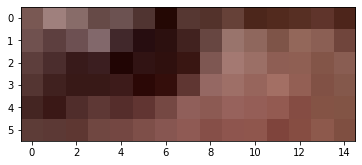

In [12]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

입력을 위해 이미지를 120x80 으로 resize 한 후, 배치(batch)를 나타낼 수 있는 4차원 텐서로 변경한다. 우선 이미지 1장에 대해서 출력을 하려 하니 지금은 배치 크기(batch size)를 1로 만들면 되겠다.

In [13]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[5.5805617e-03 1.6417061e-03]
  [1.1999835e+02 7.9988518e+01]
  [5.8220131e+01 2.9390776e+01]]]


출력결과를 뽑아보면 아래와 같이 나온다. 1행부터 좌측, 우측, 중앙 좌표를 나타낸다.

결과를 이미지에 출력해보자. **`pt`** 값은 *120x80* 으로 뽑았는데 우리가 사용하는 데이터 크기는 *60x40*이다. 따라서 **`pt`** 에 **`0.5`** 를 곱해서 그림에 출력한다.

> _(주의) **`pt`**값을 뽑을때의 이미지 크기 기준(120X80)은 고정이지만, 사용하는 데이터의 크기는 매번 달라질 것이다. 보정치 설정에 유의하자._

[0. 0.]
[120.  80.]
[58. 29.]


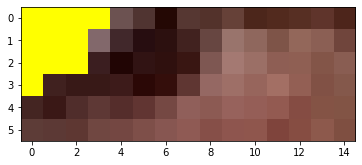

In [14]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.4).astype(int)), 3, (0,255,255), -1) # pt*0.4

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

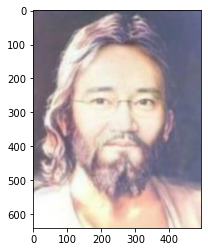

In [29]:
samfather = cv2.imread(val_data_root+'/img/samfather.jpg')
plt.imshow(cv2.cvtColor(samfather, cv2.COLOR_BGR2RGB))
plt.show()

In [30]:
np_inputs = np.expand_dims(cv2.resize(samfather, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[4.17695483e-05 5.76245875e-05]
  [1.19999985e+02 7.99999924e+01]
  [5.25740242e+01 3.88594589e+01]]]


[0. 0.]
[120.  80.]
[53. 39.]


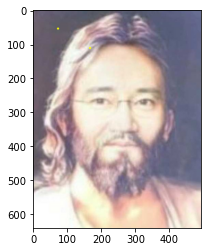

In [31]:
show = samfather.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*1.4).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

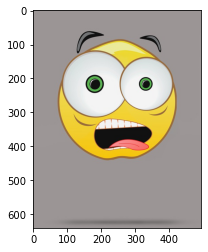

In [33]:
emoji = cv2.imread(val_data_root+'/img/emoji.jpg')
plt.imshow(cv2.cvtColor(emoji , cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
emoji_face = visualize_cam_on_image(show, emoji)

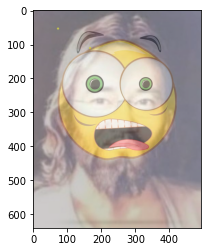

In [35]:
plt.imshow(cv2.cvtColor(emoji_face, cv2.COLOR_BGR2RGB))
plt.show()

### 회고
---
* 눈을 잘 못찾은거 같은데, 생각보다 잘되었다.

### 루브릭
---
* mean-shift를 활용하여 눈동자 검출 라벨링 추가작업을 원활히 진행하였다.<br>
(_눈이미지-라벨이미지 쌍의 추가데이터셋을 10000건 이상 충분히 확보하였다._)

    * __10000개 이상이다.__

* 눈동자 키포인트 검출 딥러닝 모델이 구현되어 안정적으로 학습이 진행되었다<br>
( _pretrained model 기반의 딥러닝 모델의 트레이닝 loss가 안정적으로 감소함을 확인하였다._)
    
    * __pretrained model로 잘 학습시켰다.__

* 모델이 검출한 눈 위치에 당황한 표정효과 눈 이미지를 합성한 이미지를 생성하였다.<br>
(_사람 얼굴 이미지에서 딥러닝 모델로 눈동자 키포인트를 검출하여 눈 이미지를 자연스럽게 합성한 결과이미지를 생성하였다._)
    
    * __잘 합성되었다.__